# Spam Vs Notspam detection complete project:)

## Import libraries

In [96]:
from os import walk
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image

%matplotlib inline

## Constants

In [97]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_HAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_HAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'

SPAM_CAT = 1
HAM_CAT = 0

THUMPS_UP = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMPS_DOWN = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

## Email body extraction

In [59]:
with open(EXAMPLE_FILE) as file:
    msg = file.read()
    
print(msg)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [60]:
# we use this part of the program to open just the message part of the emails

message = open(EXAMPLE_FILE)

is_body = False
lines = []

for line in message:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

message.close()
        
email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

In [61]:
def email_body_generator(path):
        
        for root, dirnames, filenames in walk(path):
            for file_name in filenames:
                
                filepath = join(root,file_name)
                
                stream = open(filepath, encoding='latin-1')

                is_body = False
                lines = []

                for line in stream:
                    if is_body:
                        lines.append(line)
                    elif line == '\n':
                        is_body = True
                
                stream.close()

                email_body = '\n'.join(lines)
                
                yield file_name, email_body
                

In [62]:
def df_from_directory(path, classification):
    
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MSG': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [63]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
print(spam_emails.shape)
spam_emails.head()

(1898, 2)


,MSG,CATEGORY
00454.1bb460b3ade9801644e4eb60e18d1f8d,This is a multi-part message in MIME format.\n...,1
00469.ee3b2f31459cc2ec43ae7cae00d40cf6,Lowest rates available for term life insurance...,1
00109.eda1664dd3b3c31b67e5cd04553b6546,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00291.7aa227e74e89bdd529a3875459d0d5a2,This is a multi-part message in MIME format.\n...,1
00112.be81f2f6f7940a9403c9809b4a9e243a,INVESTMENT SCHOLARS CLUB- bringing you the lat...,1


In [64]:
ham_emails = df_from_directory(EASY_HAM_1_PATH,HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_HAM_2_PATH, HAM_CAT))
print(ham_emails.shape)
ham_emails.tail()

(3901, 2)


,MSG,CATEGORY
00660.c8c35d2043accdd060b0eafe48d1da18,I just want to say - RAZOR v2 ROCKS! Under Ra...,0
00908.fa150b0b994587469112fbcb7e8cc2bc,"On Fri, 2002-07-26 at 11:50, Ian Andrew Bell w...",0
00515.b39512509fd4f39fb1cf50248c37564f,"On Mon, 19 Aug 2002 12:01:02 BST, Adrian Murph...",0
00805.77504386507753ce46fc385f2aa4ec37,"> Special Bonus with your order, you will rece...",0
00092.3a1bb2e2707717631a8f5008f7d701fc,"On Sat, Jul 20, 2002 at 07:03:17PM +0100, kevi...",0


In [65]:
data = pd.concat([spam_emails, ham_emails])
print(data.shape)
data.head()

(5799, 2)


,MSG,CATEGORY
00454.1bb460b3ade9801644e4eb60e18d1f8d,This is a multi-part message in MIME format.\n...,1
00469.ee3b2f31459cc2ec43ae7cae00d40cf6,Lowest rates available for term life insurance...,1
00109.eda1664dd3b3c31b67e5cd04553b6546,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00291.7aa227e74e89bdd529a3875459d0d5a2,This is a multi-part message in MIME format.\n...,1
00112.be81f2f6f7940a9403c9809b4a9e243a,INVESTMENT SCHOLARS CLUB- bringing you the lat...,1


In [66]:
data.tail()

,MSG,CATEGORY
00660.c8c35d2043accdd060b0eafe48d1da18,I just want to say - RAZOR v2 ROCKS! Under Ra...,0
00908.fa150b0b994587469112fbcb7e8cc2bc,"On Fri, 2002-07-26 at 11:50, Ian Andrew Bell w...",0
00515.b39512509fd4f39fb1cf50248c37564f,"On Mon, 19 Aug 2002 12:01:02 BST, Adrian Murph...",0
00805.77504386507753ce46fc385f2aa4ec37,"> Special Bonus with your order, you will rece...",0
00092.3a1bb2e2707717631a8f5008f7d701fc,"On Sat, Jul 20, 2002 at 07:03:17PM +0100, kevi...",0


## Cleaning the dataset

In [67]:
# check if any msg bodies are null
data['MSG'].isnull().values.any()

False

In [68]:
data.isnull().sum()

MSG         0
CATEGORY    0
dtype: int64

In [69]:
# check if there are empty emails 
(data.MSG.str.len() == 0).any()

True

In [70]:
# check the number of empty emails
(data.MSG.str.len() == 0).sum()

3

In [71]:
# data[data.MSG.str.len() == 0].index # or 
data[data.MSG.str.len() == 0]

,MSG,CATEGORY
cmds,,1
cmds,,1
cmds,,0


In [72]:
data.drop(['cmds'],inplace=True)

In [73]:
(data.MSG.str.len() == 0).sum()

0

## Add Doc IDs to Track emails in dataset

In [74]:
ID = range(len(data.index))
data['DOC_ID'] = ID
data.head()

,MSG,CATEGORY,DOC_ID
00454.1bb460b3ade9801644e4eb60e18d1f8d,This is a multi-part message in MIME format.\n...,1,0
00469.ee3b2f31459cc2ec43ae7cae00d40cf6,Lowest rates available for term life insurance...,1,1
00109.eda1664dd3b3c31b67e5cd04553b6546,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,2
00291.7aa227e74e89bdd529a3875459d0d5a2,This is a multi-part message in MIME format.\n...,1,3
00112.be81f2f6f7940a9403c9809b4a9e243a,INVESTMENT SCHOLARS CLUB- bringing you the lat...,1,4


In [75]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID',inplace=True)
data.head()

,MSG,CATEGORY,FILE_NAME
DOC_ID,,,
0,This is a multi-part message in MIME format.\n...,1,00454.1bb460b3ade9801644e4eb60e18d1f8d
1,Lowest rates available for term life insurance...,1,00469.ee3b2f31459cc2ec43ae7cae00d40cf6
2,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00109.eda1664dd3b3c31b67e5cd04553b6546
3,This is a multi-part message in MIME format.\n...,1,00291.7aa227e74e89bdd529a3875459d0d5a2
4,INVESTMENT SCHOLARS CLUB- bringing you the lat...,1,00112.be81f2f6f7940a9403c9809b4a9e243a


### Save file using pandas

In [76]:
data.to_json(DATA_JSON_FILE)

In [77]:
json_data = pd.read_json(DATA_JSON_FILE)
json_data.head()

,MSG,CATEGORY,FILE_NAME
0,This is a multi-part message in MIME format.\n...,1,00454.1bb460b3ade9801644e4eb60e18d1f8d
1,Lowest rates available for term life insurance...,1,00469.ee3b2f31459cc2ec43ae7cae00d40cf6
2,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00109.eda1664dd3b3c31b67e5cd04553b6546
3,This is a multi-part message in MIME format.\n...,1,00291.7aa227e74e89bdd529a3875459d0d5a2
4,INVESTMENT SCHOLARS CLUB- bringing you the lat...,1,00112.be81f2f6f7940a9403c9809b4a9e243a


## Display the number of spam and ham using pie chart

In [78]:
data.head()

,MSG,CATEGORY,FILE_NAME
DOC_ID,,,
0,This is a multi-part message in MIME format.\n...,1,00454.1bb460b3ade9801644e4eb60e18d1f8d
1,Lowest rates available for term life insurance...,1,00469.ee3b2f31459cc2ec43ae7cae00d40cf6
2,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00109.eda1664dd3b3c31b67e5cd04553b6546
3,This is a multi-part message in MIME format.\n...,1,00291.7aa227e74e89bdd529a3875459d0d5a2
4,INVESTMENT SCHOLARS CLUB- bringing you the lat...,1,00112.be81f2f6f7940a9403c9809b4a9e243a


In [79]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [80]:
amount_ham = data.CATEGORY.value_counts()[0]
amount_spam = data.CATEGORY.value_counts()[1]

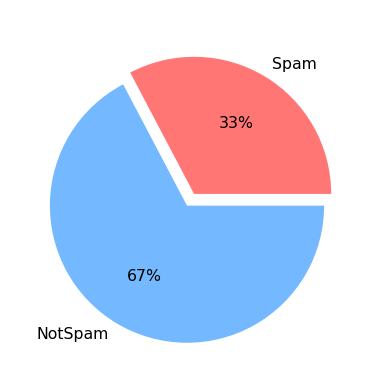

In [81]:
category_name = ['Spam', 'NotSpam']
sizes = [amount_spam ,amount_ham]
custom_color = ['#ff7675', '#74b9ff'] 


plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_name,textprops={'fontsize': 5},autopct='%1.0f%%',
                                colors = custom_color, explode = [0, 0.1])
plt.show()

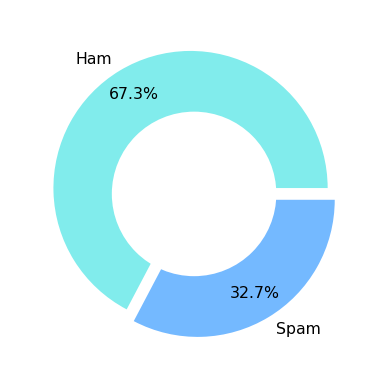

In [82]:
category_name = ['Ham', 'Spam']
sizes = [amount_ham, amount_spam]
custom_color = ['#81ecec','#74b9ff'] 
exp = [0.05, 0.05]


plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_name,textprops={'fontsize': 5},
            autopct='%1.1f%%',colors = custom_color, pctdistance = 0.8, explode=exp)
# draw a circle
centre_circle = plt.Circle((0,0),radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)


plt.show()

# Nutrual language processing
<p>NLP: use to create systems like speech recognition , document summarization, machine translation, spam detection, question answering, auto completion and so on.</p>

## Text Pre-Processing

<ul>
    <li>Converting to lower case</li>
    <li>Tokenising</li>
    <li>Removing stop words</li>
    <li>Words stemming</li>
    <li>Removing punctuation</li>  
    <li>Stripping out html tags</li>
    
</ul>

### Download The NLTK Resources(Tokenizer and Stopwords)
#### NLTK(Natural Language Toolkit)

In [83]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/programmer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [84]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/programmer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### function for cleaning our emails body:
<ul>
    <li>Converting to lower case</li>
    <li>Tokenising</li>
    <li>Removing stop words</li>
    <li>Words stemming</li>
    <li>Removing punctuation</li>  
    <li>Stripping out html tags</li>
    
</ul>
    

In [85]:
def clean_msg(msg, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    # remove html tags
    soup = BeautifulSoup(msg, 'html.parser')
    clean_text = soup.get_text()
    
    # convert to lower case and splits up the words
    words = word_tokenize(clean_text.lower())
    
    filter_words = []
    
    for word in words:
        # removing the stop words and punctuation 
        if word not in stop_words and word.isalpha():
            filter_words.append(stemmer.stem(word)) # words stemming
    
    return filter_words

In [86]:
# apply clean fun on first 3 emails body
lst = data.MSG[:3].apply(clean_msg)
new_lst = [item for ls in lst for item in ls]
new_lst[:10]

['messag',
 'mime',
 'format',
 'financi',
 'power',
 'depend',
 'competit',
 'guarante',
 'year',
 'let']

In [87]:
%%time 

nested_list = data.MSG.apply(clean_msg)

/home/programmer/.local/lib/python3.8/site-packages/bs4/__init__.py:417: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 1min 12s, sys: 140 ms, total: 1min 12s
Wall time: 1min 13s


In [88]:
nested_list.head()

DOC_ID
0    [messag, mime, format, financi, power, depend,...
1    [lowest, rate, avail, term, life, insur, take,...
2    [beauti, custom, websit, complet, beauti, cust...
3    [messag, mime, format, tba, doctor, walk, walk...
4    [invest, scholar, bring, latest, financi, epic...
Name: MSG, dtype: object

## using logic to slice dataframe

In [89]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [90]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam.head()

DOC_ID
0    [messag, mime, format, financi, power, depend,...
1    [lowest, rate, avail, term, life, insur, take,...
2    [beauti, custom, websit, complet, beauti, cust...
3    [messag, mime, format, tba, doctor, walk, walk...
4    [invest, scholar, bring, latest, financi, epic...
Name: MSG, dtype: object

In [91]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.head()

DOC_ID
1896    [url, date, suppli, came, ago, ben, hammersley...
1897    [pgp, sign, messag, hash, le, septembr, vou, a...
1898    [groov, realli, peopl, run, scare, oh, shit, c...
1899    [url, http, date, suppli, great, villag, voic,...
1900    [septemb, guido, van, rossum, said, packag, pe...
Name: MSG, dtype: object

In [92]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts() # by adding value_counts() we can find the num unique words

normal_words.shape # total unique words for ham msg

(20815,)

In [93]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

In [94]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0] # total unique words for spam msg

13242

In [95]:
spammy_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

## word cloud of ham and spam msg

In [100]:
# installing wordcloud
# pip freeze | grep wordcloud

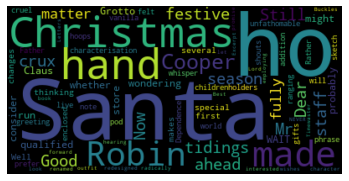

In [99]:
# creating simple wordcloud
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

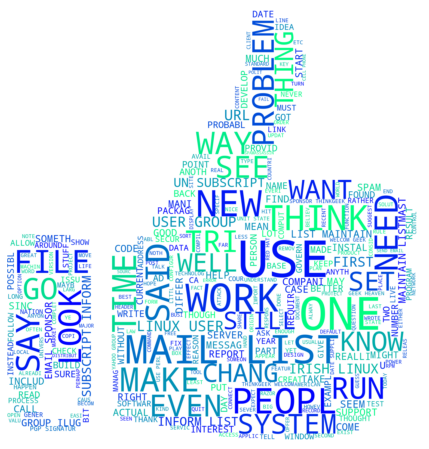

In [101]:
icon = Image.open(THUMPS_UP)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #conver image obj to an array

# generate the text as str for the word cloud

ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=300, colormap='winter')
word_cloud.generate(ham_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

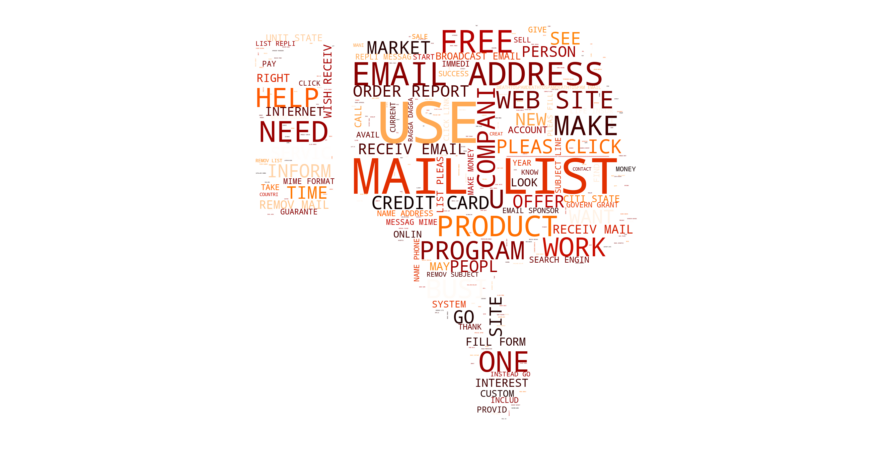

In [103]:
icon = Image.open(THUMPS_DOWN)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #conver image obj to an array

# generate the text as str for the word cloud

spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white',
                               max_words=300, colormap='gist_heat')
word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()